In [1]:
from FiftyStationsEnvironment_v1 import *
import gym
from gym import spaces
import pandas as pd
import numpy as np

In [2]:
class Torino_environment(gym.Env):
    def __init__(self, test=False, train_set_percentage=0.8, trace_file='cars-trace-1.csv',
                 min_nr_of_cpus=1, max_nr_of_cpus=50, 
                 initial_nr_of_cpus=0):#keep or discard default value? #21cpus as start?
        
        self.min_nr_of_cpus = min_nr_of_cpus
        self.max_nr_of_cpus = max_nr_of_cpus
        self.nr_of_cpus = initial_nr_of_cpus
        
        df = pd.read_csv(trace_file, nrows=1000) #nrows limit only for developing
        self.trace = df
        
        df['id'] = df['id'] = '(' + df['lat'].apply(lambda x: f'{x:.5f}') + ',' + df['lng'].apply(lambda x: f'{x:.5f}') + ')' 
        df.pop('lat')
        df.pop('lng')
        
        n_rows = df.shape[0]
        n_rows_train = int(n_rows * train_set_percentage)
        n_rows_test = n_rows - n_rows_train
        
        if test:
            self.trace = df.tail(n_rows_test)
        else:
            self.trace = df.head(n_rows_train)
        
        self.df_pops = df[['id']].drop_duplicates()        
        print("number of unique PoPs in dataset: ", self.df_pops.shape[0])        
        self.n_pops = self.df_pops.shape[0]
        
        self.n_features = 2 #numberofCPUs, Queue_length       
        self.state = np.zeros((self.n_pops, self.n_features))
        self.state[:,0] = self.nr_of_cpus
        
        #Index of station matches with index in state matrix
        self.stations = []
        for i in range(self.n_pops):
            self.stations.append(stationQueue(0))
         
        # Action is placing car at station ID and deciding on # of CPUs there
        self.action_space = spaces.Tuple([spaces.Discrete(self.n_pops), 
                                          spaces.Discrete(max_nr_of_cpus-min_nr_of_cpus)])
        print(self.action_space)
        # What is actual max of cars in queue? length of trace? intmax?
        self.observation_space = spaces.Tuple([spaces.Box(low=min_nr_of_cpus, high=max_nr_of_cpus, shape=(self.n_pops,), dtype=np.intc),
                                               spaces.Box(low=0, high=100000,shape=(self.n_pops,), dtype=np.intc)])
        print(self.observation_space)
        
        self.currentIdx = 0
        self.stopIdx = len(self.trace) - 1

        self.delayToRemoteLocation = 0.002
        self.delayTarget = 0.005
        
            
        
    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg
        
        time = self.trace['arrival_time'].iloc[self.currentIdx]     
        station = self.trace['id'].iloc[self.currentIdx]
        
        mapped_station = action[0]
        nr_of_cpus = action[1]
        
        #[index station, increase/decrease CPUs]
        # 1: placecar       
        place_delay = self.stations[mapped_station].placeCar(time)
        #delay groter maken als mappedcar niet car is
        if mapped_station != station:
            place_delay += self.delayToRemoteLocation
        # change statematrix bij ID,queulength
        # +1 assumes one car per time step
        #self.state[mapped_station, 1] = self.stations[mapped_station].getNrOfCars(time)
        self.state[mapped_station, 1] += 1        

        # 2 change CPUs + change statematrix
        cpu_delay = self.stations[mapped_station].setNrOfCPUs(nr_of_cpus, time)
        # change statematrix ID,nrofcpus
        self.state[mapped_station, 0] = nr_of_cpus #maybe with get nr of cpus?        
        
        # 3 get reward
        # JUST ADD BOTH DELAYS? WHAT IS WISE?
        #print("place delay", place_delay)
        #print("cpu delay  ", cpu_delay)
        reward = self.delayReward(place_delay + cpu_delay)        
        
        # 4 check done
        if self.currentIdx == self.stopIdx: 
            done = True
        else: 
            self.currentIdx += 1
            done = False

        # 5 info?
        info = [place_delay, cpu_delay]        
                 
        return self.state, reward, done, info
    
    def reset(self):
        # initialise all queues of PoPs
        self.state = np.zeros((self.n_pops, self.n_features))
        self.state[:,0] = self.nr_of_cpus
        # reset counter of trace
        self.currentIdx = 0
        return self.state
    
    def delayReward(self, delay):
        aux = delay/self.delayTarget
        if aux == np.float('inf'): return 0
        if aux < 0: return 0
        return aux*np.exp(-((aux**2 - 1.0)/2.0))


number of unique PoPs in dataset:  50
Tuple(Discrete(50), Discrete(49))
Tuple(Box(1, 50, (50,), int32), Box(0, 100000, (50,), int32))
----
Tuple(Discrete(50), Discrete(49))
Tuple(Box(1, 50, (50,), int32), Box(0, 100000, (50,), int32))


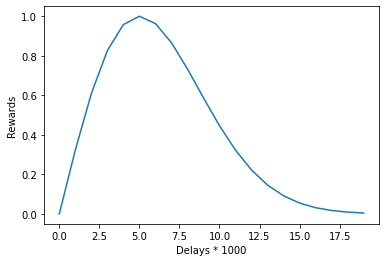

In [24]:
import matplotlib.pyplot as plt

beep = Torino_environment()
print('----')
print(beep.action_space)
print(beep.observation_space)
beep.reset()
beep.step(beep.action_space.sample())


delays = []
for delay in range(20):
    delay = delay * 0.001
    #print(delay)
    delays.append(beep.delayReward(delay))    

plt.xlabel('Delays * 1000')
plt.ylabel('Rewards')
plt.plot(delays)
plt.savefig("rewardfunction_50stations")
plt.show()